In [1]:
import pweave
pweave.rcParams['chunk']['defaultoptions'].update({'f_pos': 'tbp'})
import warnings
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)

# Modern analytic methods: Part I

In [2]:
import warnings
import random
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import statsmodels.formula.api as smf

from scipy import stats
import matplotlib.pyplot as plt
import mistat

## Introduction to Computer Age Statistics

## Data Preparation

## The Information Quality Framework

## Determining Model Performance

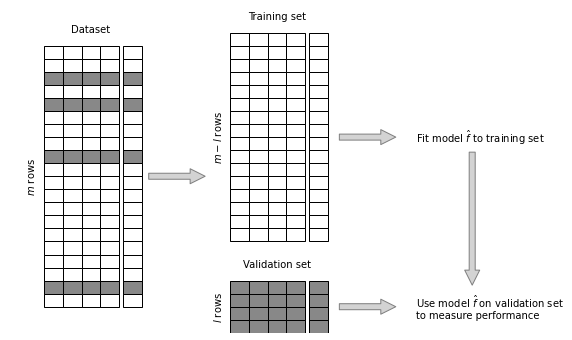

In [3]:
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

random.seed(1)

xlim = (-2, 28)
ylim = (78, 103)
nrows = 20

def drawDataRow(ax, x, y, ncolumns, alpha=1, facecolor='none', delta=0):
    for i in range(ncolumns-1):
        ax.add_patch(Rectangle((x + i, y), 1, 1, edgecolor='black',
                               facecolor=facecolor, alpha=alpha))
    ax.add_patch(Rectangle((x + ncolumns-1 + delta, y), 1, 1,
                           edgecolor='black', facecolor=facecolor, alpha=alpha))

def drawDataset(ax, x, y, nrows, ncolumns, selected=None, facecolor='white', alpha=1, delta=0):
    selected = selected or []
    for row in range(nrows):
        drawDataRow(ax, x, y-row, ncolumns, alpha=alpha, facecolor='#888888' if row in selected else facecolor,
                   delta=delta)

fig, ax = plt.subplots(figsize=(10, 6))

# Dataset
middle = 100-nrows/2+1
selected = random.sample(range(nrows), int(nrows * 0.2))
drawDataset(ax, 0, 100-1, nrows, 5, selected=selected, delta=0.25)
ax.text(2.5, 102-1, r'Dataset', ha='center')
ax.text(-1, middle-1, r'$m$ rows', va='center', rotation='vertical')

arrow = mpatches.FancyArrowPatch((5.5, middle-1), (8.75, middle-1), mutation_scale=30,
                                facecolor='lightgrey', edgecolor='grey')
ax.add_patch(arrow)

# Trainingset
ntrain = nrows - len(selected)
drawDataset(ax, 10, 100, ntrain, 5, selected=None, delta=0.25)
ax.text(12.5, 102, r'Training set', ha='center')
ax.text(9, middle+2, r'$m-l$ rows', va='center', rotation='vertical')

# Testset
ntest = len(selected)
drawDataset(ax, 10, 100 - ntrain - 3, ntest, 5, selected=list(range(ntest)), delta=0.25)
ax.text(12.5, 83, r'Validation set', ha='center')
ax.text(9, 80, r'$l$ rows', va='center', rotation='vertical')

arrow = mpatches.FancyArrowPatch((15.75, middle+2), (19, middle+2), mutation_scale=30,
                                facecolor='lightgrey', edgecolor='grey')
ax.add_patch(arrow)
ax.text(20, middle+2, r'Fit model $\hat{f}$ to training set', va='center')

arrow = mpatches.FancyArrowPatch((15.75, 80), (19, 80), mutation_scale=30,
                                facecolor='lightgrey', edgecolor='grey')
ax.add_patch(arrow)
ax.text(20, 80, 'Use model ' + r'$\hat{f}$ on validation set' + '\nto measure performance', va='center')

arrow = mpatches.FancyArrowPatch((23, middle+1), (23, 81.5), mutation_scale=30,
                                facecolor='lightgrey', edgecolor='grey')
ax.add_patch(arrow)


ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.axis('off')
plt.show()

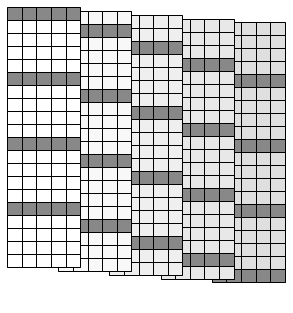

In [4]:
random.seed(2)

xlim = (0, 19.1)
ylim = (78, 101)
nrows = 20
colorCh1 = 'FFEEDDCBA9876'
colorCh2 = 'F8F8F8FBA9876'

fig, ax = plt.subplots(figsize=(5, 5.5))
for nboot in reversed(range(5)):
    dx = nboot*0.6
    dx = nboot*3.5
    dy = nboot*0.3
    facecolor = '#'
    for _ in range(3):
        facecolor += colorCh1[nboot] + colorCh2[nboot]
    selected = range(nboot, nrows, 5)
    drawDataset(ax, 0 + dx, 100 - dy, nrows, 5, selected=selected, facecolor=facecolor)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.axis('off')
plt.show()

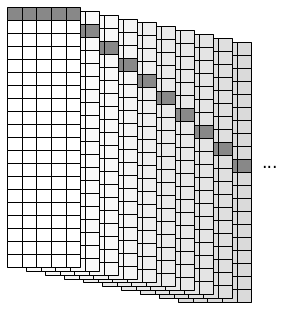

In [5]:
fig, ax = plt.subplots(figsize=(5, 5.5))
colorCh1 = 'FFFFEEEEDDDDCCCCBBBBAAAA'
colorCh2 = 'FA84' * 10

for nboot in reversed(range(10)):
    dx = nboot*1.3
    dy = nboot*0.3
    facecolor = '#'
    for _ in range(3):
        facecolor += colorCh1[nboot] + colorCh2[nboot]
    selected = [nboot]
    drawDataset(ax, 0 + dx, 100 - dy, nrows, 5, selected=selected, facecolor=facecolor)
ax.text(17.4, 89, '...', va='center', fontsize='xx-large')

ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.axis('off')
plt.show()


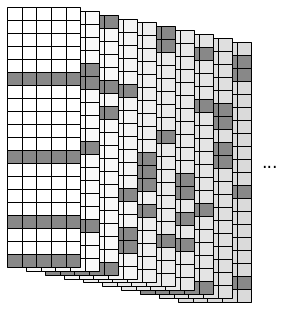

In [6]:
fig, ax = plt.subplots(figsize=(5, 5.5))
# Dataset
for nboot in reversed(range(10)):
    dx = nboot*1.3
    dy = nboot*0.3
    facecolor = '#'
    for _ in range(3):
        facecolor += colorCh1[nboot] + colorCh2[nboot]

    selected = random.sample(range(nrows), int(nrows * 0.2))
    drawDataset(ax, 0 + dx, 100 - dy, nrows, 5, selected=selected, alpha=1, facecolor=facecolor)
ax.text(17.4, 89, '...', va='center', fontsize='xx-large')

ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.axis('off')
plt.show()

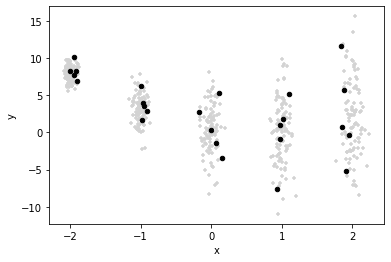

In [7]:
np.random.seed(0)
yerr = 0.2
yerr = 1
def createData(n):
    x = [-2, -1, 0, 1, 2]
    data = []
    for i, xi in enumerate(x):
        for _ in range(n):
            dx = (i+5) * 0.01 * stats.norm.rvs()
            dy = (i+1) * yerr * stats.norm.rvs()
            data.append({'x': xi+dx, 'y': dy + (xi - 0.75) ** 2 + 0.3, 'group': i})
    return pd.DataFrame(data)
df = createData(5)
valid_df = createData(100)
ax = valid_df.plot.scatter(x='x', y='y', color='lightgrey', marker='+')
df.plot.scatter(x='x', y='y', ax=ax, color='black')
plt.show()

In [8]:
formula = 'y ~ 1 + x + np.power(x, 2)'
def sample80(df):
  """ Sample 80% of the dataset using RSWR """
  return df.sample(int(0.8 * len(df)), replace=True)
stratR2 = []
for _ in range(100):
    stratSample = df.groupby('group').apply(lambda x: sample80(x))
    model = smf.ols(formula=formula, data=stratSample).fit()
    stratR2.append(model.rsquared)
sampleR2 = []
for _ in range(100):
    sample = sample80(df)
    model = smf.ols(formula=formula, data=sample).fit()
    sampleR2.append(model.rsquared)

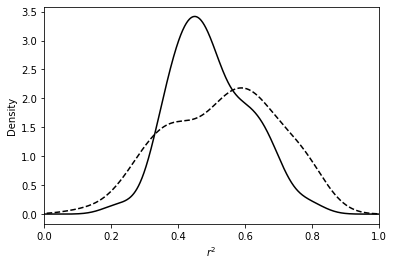

In [9]:
ax = pd.Series(stratR2).plot.density(color='black')
pd.Series(sampleR2).plot.density(ax=ax, color='black', linestyle='--')
ax.set_xlim(0, 1.0)
ax.set_xlabel(r'$r^2$')
plt.show()

## Decision Trees

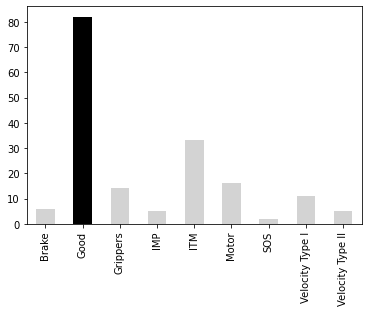

In [10]:
sensors = mistat.load_data('SENSORS.csv')
dist = sensors['testResult'].value_counts()
dist = dist.sort_index()
ax = dist.plot.bar(color='lightgrey')
ax.patches[dist.index.get_loc('Good')].set_facecolor('black')
plt.show()

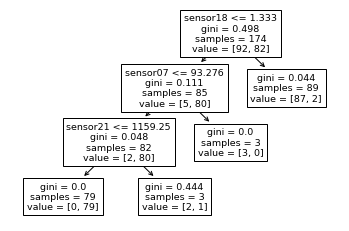

In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

predictors = [c for c in sensors.columns if c.startswith('sensor')]
outcome = 'status'
X = sensors[predictors]
y = sensors[outcome]

# Train the model
clf = DecisionTreeClassifier(ccp_alpha=0.012, random_state=0)
clf.fit(X, y)

# Visualization of tree
plot_tree(clf, feature_names=list(X.columns))
plt.show()

In [12]:
# Text representation of tree
print(export_text(clf, feature_names=list(X.columns)))

|--- sensor18 <= 1.33
|   |--- sensor07 <= 93.28
|   |   |--- sensor21 <= 1159.25
|   |   |   |--- class: Pass
|   |   |--- sensor21 >  1159.25
|   |   |   |--- class: Fail
|   |--- sensor07 >  93.28
|   |   |--- class: Fail
|--- sensor18 >  1.33
|   |--- class: Fail



In [13]:
from dtreeviz.trees import dtreeviz

def viz2pdf(viz, pdfFile):
  from svglib.svglib import svg2rlg
  from reportlab.graphics import renderPDF
  from tempfile import NamedTemporaryFile
  with NamedTemporaryFile(mode='w+', suffix='.svg') as f:
    f.write(viz.svg())
    f.flush()
    f.seek(0)
    drawing = svg2rlg(f.name)
    renderPDF.drawToFile(drawing, pdfFile)


# the dtreeviz methods requires the classifier to be trained with a numerical
# representation of the classes
X = sensors[predictors]
y = np.array([1 if yi == 'Pass' else 0 for yi in sensors[outcome]])

# Train the model
clf = DecisionTreeClassifier(ccp_alpha=0.012, random_state=0)
clf.fit(X, y)

warnings.simplefilter('ignore', category=UserWarning)
viz = dtreeviz(clf, X, y,
               target_name=outcome,
               feature_names=X.columns,
               class_names=['Fail', 'Pass'])
warnings.simplefilter('default', category=UserWarning)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


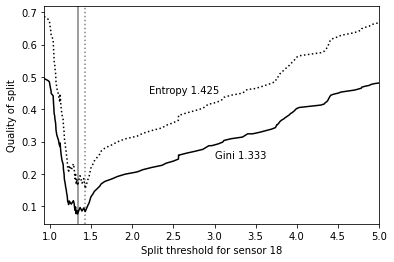

In [14]:
sensor18 = np.array(sensors['sensor18'])
status =  sensors['status']
x = np.array(sorted(sensor18))
split = []
gini = []
entropy = []
N = len(x)
# Iterate over pairs of sensor data
for theta in zip(x[1:], x[:-1]):
    theta = 0.5 * (theta[0] + theta[1])
    left = sensor18 <= theta
    right = sensor18 > theta
    Nleft = sum(left)
    Nright = sum(right)
    pleft = status[left].value_counts().values / Nleft
    pright = status[right].value_counts().values / Nright
    split.append(theta)
    gini.append(Nleft * np.sum(pleft*(1-pleft)) / N + Nright * np.sum(pright*(1-pright)) / N)
    entropy.append(- Nleft * np.sum(pleft*np.log(pleft)) / N - Nright * np.sum(pright*np.log(pright)) / N)

fig, ax = plt.subplots()
ax.axvline(split[np.argmin(gini)], color='grey')
ax.axvline(split[np.argmin(entropy)], color='grey', ls=':')
ax.plot(split, gini, color='black')
ax.plot(split, entropy, color='black', ls=':')
ax.set_xlim(min(split), 5)
ax.set_xlabel('Split threshold for sensor 18')
ax.set_ylabel('Quality of split')
ax.text(2.2, 0.45, f'Entropy {split[np.argmin(entropy)]:.3f}')
ax.text(3, 0.25, f'Gini {split[np.argmin(gini)]:.3f}')
plt.show()

Probabilities of missclassified data points
[[0.97752809 0.02247191]
 [0.97752809 0.02247191]
 [0.66666667 0.33333333]]
Confusion matrix
[[92  0]
 [ 3 79]]


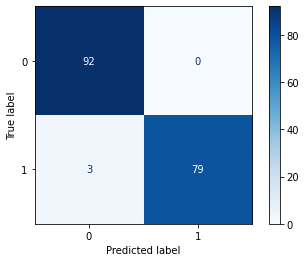

In [15]:
# missclassification probabilities
print('Probabilities of missclassified data points')
print(clf.predict_proba(X.loc[clf.predict(X) != y,:]))

# actual in rows / predicted in columns
print('Confusion matrix')
cm = confusion_matrix(y, clf.predict(X))
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

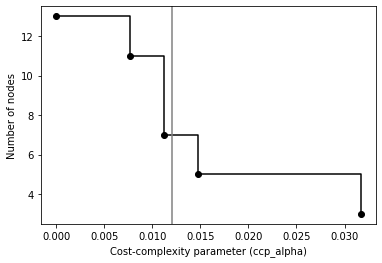

In [16]:
# Code to analyze tree depth vs alpha
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X, y)
    clfs.append(clf)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
fig, ax = plt.subplots()
ax.plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post",
        color='black')
ax.set_xlabel("Cost-complexity parameter (ccp_alpha)")
ax.set_ylabel("Number of nodes")
ax.axvline(0.012, color='grey')
plt.show()

## Ensemble Models

In [17]:
predictors = [c for c in sensors.columns if c.startswith('sensor')]
outcome = 'status'
X = sensors[predictors]
y = sensors[outcome]

# Train the model
clf = RandomForestClassifier(ccp_alpha=0.012, random_state=0)
clf.fit(X, y)

# actual in rows / predicted in columns
print('Confusion matrix')
print(confusion_matrix(y, clf.predict(X)))

Confusion matrix
[[92  0]
 [ 0 82]]


In [18]:
# On some versions of MACOS, running xgboost can fail. Uncomment the following
# lines to avoid this.
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [19]:
from xgboost import XGBClassifier

predictors = [c for c in sensors.columns if c.startswith('sensor')]
outcome = 'status'
X = sensors[predictors]
# Encode outcome as 0 (Fail) and 1 (Pass)
y = np.array([1 if s == 'Pass' else 0 for s in sensors[outcome]])

# Train the model
xgb = XGBClassifier(objective='binary:logistic', subsample=.63,
                    eval_metric='logloss', use_label_encoder=False)
xgb.fit(X, y)

# actual in rows / predicted in columns
print('Confusion matrix')
print(confusion_matrix(y, xgb.predict(X)))

Confusion matrix
[[92  0]
 [ 0 82]]


## Na\"ive Bayes Classifier

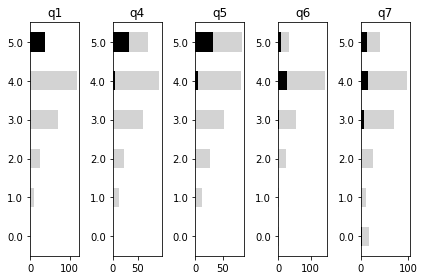

In [20]:
abc = mistat.load_data('ABC.csv')
all_questions = [c for c in abc.columns if c.startswith('q')]
abc[all_questions] = abc[all_questions].astype('category')

questions = ['q1', 'q4', 'q5', 'q6', 'q7']
q1_5 = (abc['q1'] == 5)

fig, axes = plt.subplots(ncols=len(questions))
for ax, question in zip(axes, questions):
  response = abc[question]
  df = pd.DataFrame([
    {satisfaction: counts for satisfaction, counts
      in response.value_counts().iteritems()},
    {satisfaction: counts for satisfaction, counts
      in response[q1_5].value_counts().iteritems()},
  ])
  df = df.transpose()  # flip columns and rows
  # add rows of 0 for missing satisfaction
  for s in range(6):
    if s not in df.index:
      df.loc[s] = [0, 0]
  df = df.fillna(0)  # change missing values to 0
  df = df.sort_index()  # the index contains the satisfaction
  df.columns = ['counts', 'counts_q1_5']  # rename the columns
  df['counts'].plot.barh(y='index', ax=ax, color='lightgrey')
  df['counts_q1_5'].plot.barh(y='index', ax=ax, color='black')
  ax.set_ylim(-0.5, 5.5)
  ax.set_title(question)
plt.tight_layout()
plt.show()

In [21]:
predictors = list(all_questions)
predictors.remove('q1')
target = 'q1'
# q1 has missing values - remove rows from dataset
q1_missing = abc[target].isna()
X = abc.loc[~q1_missing, predictors]
y = abc.loc[~q1_missing, target]

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X = imp.fit_transform(X)

In [22]:
nb_model = MultinomialNB()
nb_model.fit(X, y)
print(confusion_matrix(y, nb_model.predict(X)))
print(accuracy_score(y, nb_model.predict(X)))

[[ 7  2  2  0  0]
 [ 3 14  4  4  0]
 [ 8  6 35 16  5]
 [ 9  1 12 66 30]
 [ 3  0  2 12 21]]
0.5458015267175572


In [23]:
dt_model = DecisionTreeClassifier(ccp_alpha=0.014, random_state=0)
_ = dt_model.fit(X, y)

In [24]:
print(confusion_matrix(y, dt_model.predict(X)))
print(accuracy_score(y, dt_model.predict(X)))

[[  8   3   0   0   0]
 [  1  19   4   1   0]
 [  2   4  51  13   0]
 [  1   2  13 102   0]
 [  0   0   0  19  19]]
0.7595419847328244


In [25]:
rf_model = RandomForestClassifier(ccp_alpha=0.014, random_state=0)
_ = rf_model.fit(X, y)

In [26]:
print(confusion_matrix(y, rf_model.predict(X)))
print(accuracy_score(y, rf_model.predict(X)))

[[  4   2   4   1   0]
 [  0  14   8   3   0]
 [  0   0  64   6   0]
 [  0   0   1 116   1]
 [  0   0   0  14  24]]
0.8473282442748091


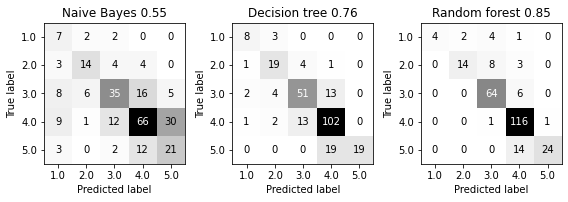

In [27]:
fig, axes = plt.subplots(ncols=3, figsize=(8, 3))
axes[0].set_title(f'Naive Bayes {accuracy_score(y, nb_model.predict(X)):.2f}')
ConfusionMatrixDisplay.from_estimator(nb_model, X, y, ax=axes[0],
  cmap=plt.cm.Greys, colorbar=False)
axes[1].set_title(f'Decision tree {accuracy_score(y, dt_model.predict(X)):.2f}')
ConfusionMatrixDisplay.from_estimator(dt_model, X, y, ax=axes[1],
  cmap=plt.cm.Greys, colorbar=False)
axes[2].set_title(f'Random forest {accuracy_score(y, rf_model.predict(X)):.2f}')
ConfusionMatrixDisplay.from_estimator(rf_model, X, y, ax=axes[2],
  cmap=plt.cm.Greys, colorbar=False)
plt.tight_layout()
plt.show()

## Neural Networks

In [28]:
abc = mistat.load_data('ABC.csv')
all_questions = [c for c in abc.columns if c.startswith('q')]
abc[all_questions] = abc[all_questions].astype('category')
predictors = list(all_questions)
predictors.remove('q1')
target = 'q1'
# q1 has missing values - remove rows from dataset
q1_missing = abc[target].isna()
X = abc.loc[~q1_missing, predictors]
y = abc.loc[~q1_missing, target]

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X = imp.fit_transform(X)

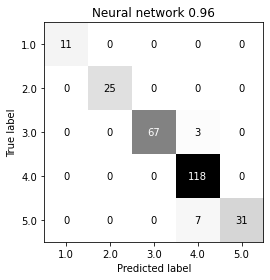

In [29]:
# scale predictor variables to interval (0, 1)
X = MinMaxScaler().fit_transform(X)

clf = MLPClassifier(hidden_layer_sizes=(4, ), activation='logistic',
                    solver='lbfgs', max_iter=1000,
                    random_state=1)
clf.fit(X, y)
# clf.predict(X)
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_estimator(clf, X, y, ax=ax,
  cmap=plt.cm.Greys, colorbar=False)

ax.set_title(f'Neural network {accuracy_score(y, clf.predict(X)):.2f}')
plt.tight_layout()

## Clustering Methods

### Hierarchical Clustering

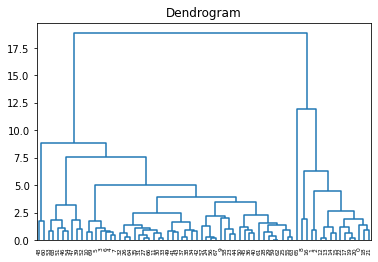

In [30]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from mistat import plot_dendrogram

almpin = mistat.load_data('ALMPIN.csv')

scaler = StandardScaler()
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

X = scaler.fit_transform(almpin)
model = model.fit(X)

fig, ax = plt.subplots()
plot_dendrogram(model, ax=ax)
ax.set_title('Dendrogram')
plt.show()

### $K$-means Clustering

In [31]:
from sklearn.cluster import KMeans

almpin = mistat.load_data('ALMPIN.csv')

scaler = StandardScaler()
X = scaler.fit_transform(almpin)
model = KMeans(n_clusters=9, random_state=1).fit(X)
print('Cluster membership (first two data points)')
print(model.predict(X)[:2])
print()
print('Distance to cluster center (first two data points)')
model.transform(X)[:2,:]

Cluster membership (first two data points)
[1 8]

Distance to cluster center (first two data points)


array([[3.33269867, 1.04495283, 9.69783046, 2.48008435, 5.57643458,
        3.98844284, 3.77738831, 2.52221759, 2.4300689 ],
       [5.66992727, 2.7429881 , 7.9467812 , 4.78497545, 7.75144534,
        4.68141833, 5.77196141, 4.89153706, 0.4705252 ]])

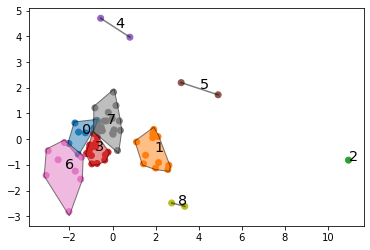

In [32]:
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull

# use PCA to map the dataset into a 2D space
pca = PCA(n_components=2).fit(X)
coord = pca.transform(X)

fig, ax = plt.subplots()
df = pd.DataFrame({'x': coord[:,0], 'y': coord[:,1],
                   'cluster': model.predict(X)})
colors = [f'C{i}' for i in model.predict(X)]
ax.scatter(df.x, df.y, color=[f'C{cl}' for cl in df.cluster])

from matplotlib.patches import Polygon
for cl, x in df.groupby('cluster'):
  x = x.values[:, :2]
  cent = np.mean(x, axis=0)
  if len(x) == 1:
    pass
  elif len(x) == 2:
    ax.plot(x[:,0], x[:,1], color='black', alpha=0.5)
  else:
    hull = ConvexHull(x)
    pts = []
    for pt in x[hull.simplices]:
        pts.append(pt[0].tolist())
        pts.append(pt[1].tolist())

    pts.sort(key=lambda p: np.arctan2(p[1] - cent[1],
                                    p[0] - cent[0]))
    pts = pts[0::2]  # Deleting duplicates
    pts.insert(len(pts), pts[0])
    k = 1.1
    color = 'green'
    poly = Polygon(k*(np.array(pts)- cent) + cent, edgecolor='black',
                   facecolor=f'C{cl}', alpha=0.5)
    poly.set_capstyle('round')
    ax.add_patch(poly)
  ax.text(*cent, f'{cl}', fontsize='x-large')
plt.show()

### Cluster Number Selection

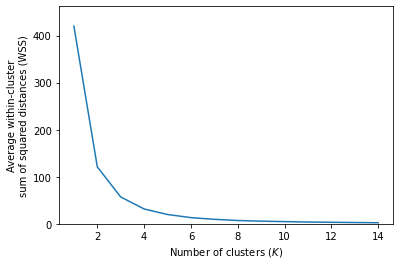

In [33]:
inertia = []

for n_clusters in range(1, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 15), 'inertia': inertia})

ax = inertias.plot(x='n_clusters', y='inertia')
ax.set_xlabel(r'Number of clusters ($K$)')
ax.set_ylabel('Average within-cluster\nsum of squared distances (WSS)')
ax.set_ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()

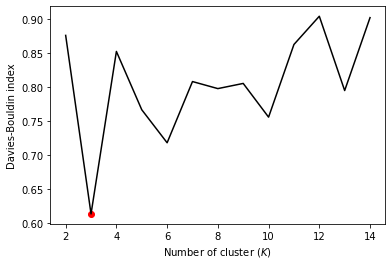

In [34]:
from sklearn import metrics

ss = []
range_n_clusters = list(range(2, 15))
for n_clusters in range_n_clusters:
   clusterer = KMeans(n_clusters = n_clusters, random_state=1)
   cluster_labels = clusterer.fit_predict(X)

   score = metrics.davies_bouldin_score(X, cluster_labels)
   ss.append(score)
opt_index = np.argmin(ss)

fig, ax = plt.subplots()
ax.plot(range_n_clusters, ss,'-', color='black')
ax.scatter(range_n_clusters[opt_index], ss[opt_index], color='red')
ax.set_xlabel(r'Number of cluster ($K$)')
ax.set_ylabel('Davies-Bouldin index')
plt.show()

## Chapter Highlights

## Exercises